In [1]:
print("""
@File         : ch10_forecasting_multiple_time_series.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-14 18:10:58
@Email        : cuixuanstephen@gmail.com
@Description  : 
""")


@File         : ch10_forecasting_multiple_time_series.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-14 18:10:58
@Email        : cuixuanstephen@gmail.com
@Description  : 



In [2]:
%cd ../

d:\Time-Series\TSFP


In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from utils.print_info import print_adf_result

warnings.filterwarnings("ignore")

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


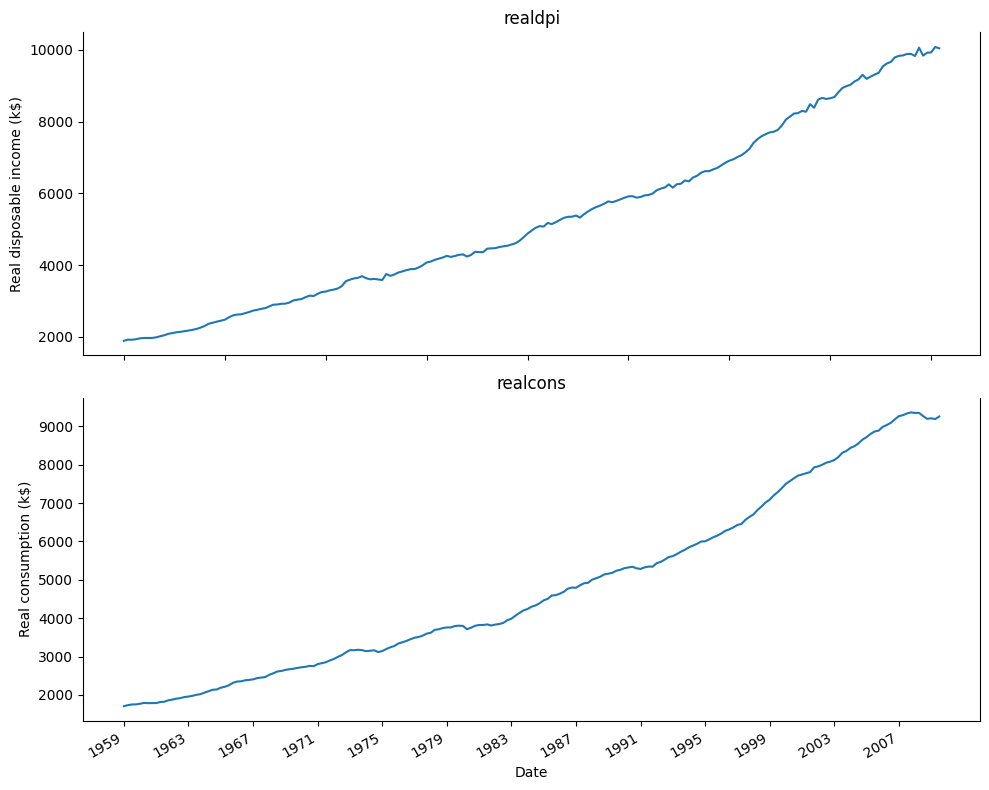

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(macro_econ_data["realdpi"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Real disposable income (k$)")
ax1.set_title("realdpi")
ax1.spines["top"].set_alpha(0)
ax2.plot(macro_econ_data["realcons"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Real consumption (k$)")
ax2.set_title("realcons")
ax2.spines["top"].set_alpha(0)
plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()
plt.tight_layout()

In [6]:
ad_fuller_result_1 = adfuller(macro_econ_data["realdpi"])
print_adf_result(ad_fuller_result_1, 'realdpi')
print("\n---------------------\n")
ad_fuller_result_2 = adfuller(macro_econ_data["realcons"])
print_adf_result(ad_fuller_result_1, 'realcons')

realdpi
ADF Statistic: 2.9860253519546847
p-value: 1.0

---------------------

realcons
ADF Statistic: 2.9860253519546847
p-value: 1.0


In [7]:
ad_fuller_result_1 = np.diff(macro_econ_data["realdpi"], n=1)
print_adf_result(ad_fuller_result_1, "realcons")
print("\n---------------------\n")
ad_fuller_result_2 = np.diff(macro_econ_data["realcons"], n=1)
print_adf_result(ad_fuller_result_2, "realcons")

realcons
ADF Statistic: 32.799999999999955
p-value: -3.2999999999999545

---------------------

realcons
ADF Statistic: 26.299999999999955
p-value: 18.09999999999991


In [8]:
from utils.optimize import optimize_VAR

endog = macro_econ_data[["realdpi", "realcons"]]
endog_diff = endog.diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

 80%|████████  | 12/15 [37:24<31:13, 624.60s/it]

Running the function returns a DataFrame in which we see that $p = 3$ has the lowest AIC value of all. Therefore, the selected model is a VAR(3) model, meaning that the past three values of each time series are used to forecast the other time series.

In [ ]:
print("realcons Granger-causes realdpi?\n")
print("------------------")
granger_1 = grangercausalitytests(
    macro_econ_data[["realdpi", "realcons"]].diff()[1:], 3
)